In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as A
import keras.backend as K
from IPython.display import clear_output

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Folder contains predictions through epochs
os.mkdir('/kaggle/working/Images')

In [3]:
%load_ext tensorboard

In [4]:
strategy = tf.distribute.MirroredStrategy()
print(f'We are using {strategy.num_replicas_in_sync} GPUs!')

We are using 2 GPUs!


In [5]:
def visualize_mask(image, mask):
    CLASSES = ['background', 'square', 'circle', 'triangle', 'star']
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(10, 10))
    ax[0].set_title('Ori Image')
    ax[0].imshow(image)
    ax[0].axis('off')
    for i in range(1, 6, 1):
        ax[i].set_title(CLASSES[i - 1])
        ax[i].imshow(mask[:, :, i - 1])
        ax[i].axis('off')
    plt.show()

In [ ]:
class Dataset:
    CLASSES = ['background', 'square', 'circle', 'triangle', 'star']
    # imgs_dir: folder of images
    # masks_dir: folder of masks
    # classes: classes we use
    # colors of annotation masks
    square = (250, 50, 83) #1
    circle = (36, 179, 83) #2
    triangle = (42, 125, 209) #3
    star = (115, 51, 128) #4
    background = (0, 0, 0) #0
    def __init__(self, imgs_dir, masks_dir, classes, augmentation=True, preprocessing=True):
        self.images_id = [img.split('.')[0] for img in os.listdir(imgs_dir)]
        if '' in self.images_id:
            self.images_id.remove('')
        self.images_path = [os.path.join(imgs_dir, img_id) + '.jpg' for img_id in self.images_id]
        self.masks_path = [os.path.join(masks_dir, img_id) + '.png' for img_id in self.images_id]
        self.images = []
        self.masks = []
        self.class_value = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        for i in range(len(self.images_id)):
            image = cv2.imread(self.images_path[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ori_mask = cv2.imread(self.masks_path[i])
            if ori_mask is not None:
                ori_mask = cv2.cvtColor(ori_mask, cv2.COLOR_BGR2RGB)
            else:
                ori_mask = np.zeros((256, 256, 3))
            mask = np.zeros((ori_mask.shape[0], ori_mask.shape[1]), dtype=np.uint8)
            mask[np.all(ori_mask == self.square, axis=-1)] = 1
            mask[np.all(ori_mask == self.circle, axis=-1)] = 2
            mask[np.all(ori_mask == self.triangle, axis=-1)] = 3
            mask[np.all(ori_mask == self.star, axis=-1)] = 4
            mask[np.all(ori_mask == self.background, axis=-1)] = 0
            masks = [(mask == v) for v in self.class_value]
            mask_output = np.stack(masks, axis=-1).astype(np.float32)
            self.images.append(image)
            self.masks.append(mask_output)
        if self.augmentation:
            transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
#                 A.CropAndPad(percent=(-0.1, -0.05), p=5),
#                 A.RandomRotate90(),
                A.Transpose(p=0.5),
                A.Perspective(p=0.8),
                A.RandomBrightnessContrast((-0.2, 0.2), p=0.5)
            ])
            for i in range(len(self.images_id)):
                for j in range(3):
                    transformed1 = transform(image=self.images[i], mask=self.masks[i])
                    self.images.append(transformed1['image'])
                    self.masks.append(transformed1['mask'])

    def __getitem__(self, index):
        image = self.images[index]
        if self.preprocessing:
            image = image.astype(np.float32)
            image = image / 255.0
        return image, self.masks[index]


    def __len__(self):
        return len(self.images)


In [7]:
cls = ['background', 'square', 'circle', 'triangle', 'star']

train_dataset = Dataset('/kaggle/input/demo1-4/Demo1Images/images', '/kaggle/input/demo1-4/Demo1Images/annotation', cls, True)
val_dataset = Dataset('/kaggle/input/demo1-4/Demo1Images/val_images', '/kaggle/input/demo1-4/Demo1Images/val_annotation', cls, True)


[ WARN:0@8.760] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/demo1-4/Demo1Images/annotation/109.png'): can't open/read file: check file path/integrity
[ WARN:0@8.809] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/demo1-4/Demo1Images/annotation/187.png'): can't open/read file: check file path/integrity
[ WARN:0@8.836] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/demo1-4/Demo1Images/annotation/76.png'): can't open/read file: check file path/integrity
[ WARN:0@8.855] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/demo1-4/Demo1Images/annotation/71.png'): can't open/read file: check file path/integrity
[ WARN:0@8.925] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/demo1-4/Demo1Images/annotation/182.png'): can't open/read file: check file path/integrity
[ WARN:0@8.943] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/demo1-4/Demo1Images/annotation/185.png'): can't open/read file: check file path/integrity
[ WARN:0@8.9

In [9]:
print(f'Number of train samples: {len(train_dataset)}')
print(f'Number of validation samples: {len(val_dataset)}')
                                     

Number of train samples: 1032
Number of validation samples: 140


In [10]:
class DataLoader(tf.keras.utils.Sequence):
    """
    dataset:
    batch_size:
    shuffle: shuffle data or not
    """
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    def __getitem__(self, index):
        x = []
        y = []
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        for j in indexes:
            x.append(self.dataset[j][0])
            y.append(self.dataset[j][1])
        X = np.stack(x, axis=0)
        Y = np.stack(y, axis=0)
        batch = (X, Y)
        return batch
    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.dataset))
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [11]:
train_dataloader = DataLoader(train_dataset, 16, True)
val_dataloader = DataLoader(val_dataset, 16, True)

In [12]:
def build_model():
    input = tf.keras.Input(shape=(256, 256, 3))
    conv1 = tf.keras.layers.Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(input)
    conv = tf.keras.layers.Conv2D(16, (3, 3), strides=2, activation='relu', padding='same')(conv1)
    conv = tf.keras.layers.DepthwiseConv2D((3, 3), strides=1, activation='relu', padding='same')(conv)
    conv2 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, activation='relu', padding='same')(conv)
    conv = tf.keras.layers.DepthwiseConv2D((3, 3), strides=2, activation='relu', padding='same')(conv2)
    conv = tf.keras.layers.Conv2D(32, (1, 1), strides=1, activation='relu', padding='same')(conv)
    conv = tf.keras.layers.DepthwiseConv2D((3, 3), strides=1, activation='relu', padding='same')(conv)
    conv3 = tf.keras.layers.Conv2D(64, (1, 1), strides=1, activation='relu', padding='same')(conv)
    conv = tf.keras.layers.DepthwiseConv2D((3, 3), strides=2, activation='relu', padding='same')(conv3)
    conv = tf.keras.layers.Conv2D(64, (1, 1), strides=1, activation='relu', padding='same')(conv)
    conv = tf.keras.layers.DepthwiseConv2D((3, 3), strides=1, activation='relu', padding='same')(conv)
    conv4 = tf.keras.layers.Conv2D(128, (1, 1), strides=1, activation='relu', padding='same')(conv)
    conv = tf.keras.layers.DepthwiseConv2D((3, 3), strides=2, activation='relu', padding='same')(conv4)
    conv = tf.keras.layers.Conv2D(128, (1, 1), strides=1, activation='relu', padding='same')(conv)
    
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.DepthwiseConv2D((3, 3), strides=1, activation='relu', padding='same')(conv)
    conv = tf.keras.layers.Conv2D(128, (1, 1), strides=1, activation='relu', padding='same')(conv)
    conv = tf.keras.layers.DepthwiseConv2D((3, 3), strides=1, activation='relu', padding='same')(conv)
    
    conv = tf.keras.layers.Conv2D(128, (1, 1), strides=1, activation='relu', padding='same')(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)

    # Up sample block     
    deconv2 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=2, padding='same', activation='relu')(conv)
    concat2 = tf.keras.layers.concatenate([deconv2, conv4])
    conv = tf.keras.layers.DepthwiseConv2D((3, 3), strides=1, activation='relu', padding='same')(concat2)
    conv = tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)

    
    deconv3 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=2, padding='same', activation='relu')(conv)
    concat3 = tf.keras.layers.concatenate([deconv3, conv3])
    conv = tf.keras.layers.DepthwiseConv2D((3, 3), strides=1, activation='relu', padding='same')(concat3)
    conv = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(conv)
    
    deconv4 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=2, padding='same', activation='relu')(conv)
    concat4 = tf.keras.layers.concatenate([deconv4, conv2])
    conv = tf.keras.layers.DepthwiseConv2D((3, 3), strides=1, activation='relu', padding='same')(concat4)
    conv = tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(conv)
    
    deconv5 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=2, padding='same', activation='relu')(conv)
    concat5 = tf.keras.layers.concatenate([deconv5, conv1])
    conv = tf.keras.layers.Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(concat5)
    conv = tf.keras.layers.DepthwiseConv2D((3, 3), strides=1, activation='relu', padding='same')(conv)
    conv = tf.keras.layers.Conv2D(16, (1, 1), strides=1, activation='relu', padding='same')(conv)
    output = tf.keras.layers.Conv2D(5, (1, 1), strides=1, activation='softmax', padding='same')(conv)
    
    model = tf.keras.Model(input, output)
    return model
unet_model = build_model()
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [13]:
ori_img = cv2.imread('/kaggle/input/demo1-4/Demo1Images/val_images/227.jpg')
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
val_img = ori_img.astype(np.float32)
val_img = val_img / 255.0
val_img = np.expand_dims(val_img, axis=0)
print(val_img.shape)

(1, 256, 256, 3)


In [14]:
def create_mask(mask_output):
    r = np.zeros((256, 256), dtype=np.uint8)
    g = np.zeros((256, 256), dtype=np.uint8)
    b = np.zeros((256, 256), dtype=np.uint8)
    r[mask_output == 1] = 250
    r[mask_output == 2] = 36
    r[mask_output == 3] = 42
    r[mask_output == 4] = 115

    g[mask_output == 1] = 50
    g[mask_output == 2] = 179
    g[mask_output == 3] = 125
    g[mask_output == 4] = 51

    b[mask_output == 1] = 83
    b[mask_output == 2] = 83
    b[mask_output == 3] = 209
    b[mask_output == 4] = 128

    output = np.stack([r, g, b], axis=-1)
    return output


In [15]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        pred = unet_model.predict(val_img)
        mask = create_mask(np.argmax(pred[0], axis=-1))
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
        ax[0].imshow(ori_img)
        ax[0].set_title('Ori Image')
        ax[1].imshow(mask)
        ax[1].set_title('Mask')
        ax[0].axis('off')
        ax[1].axis('off')
        plt.savefig(f'/kaggle/working/Images/Epoch{epoch}')
        plt.show()

In [16]:
def dice(y_true, y_pred, smooth = .001):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    dice = (2 * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    return dice

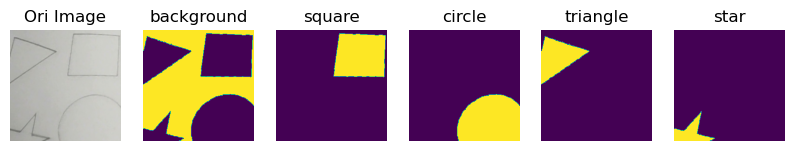

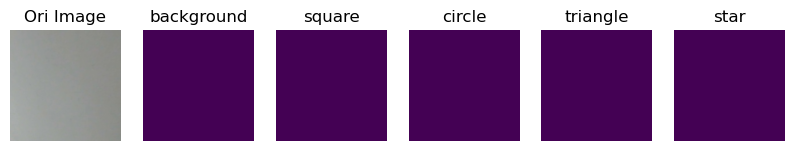

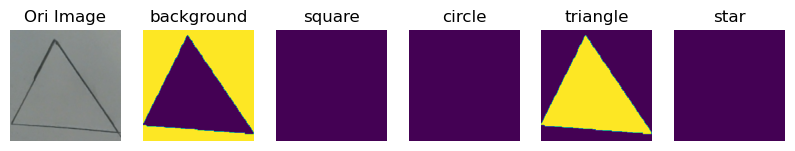

In [17]:
for i in range(3):
    visualize_mask(train_dataloader[0][0][i], train_dataloader[0][1][i])

In [18]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=6e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[dice, 'accuracy'])

In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=7, factor=0.8, min_lr=1e-5),
    CustomCallback(),
]

1/1 [==============================] - 0s 21ms/step


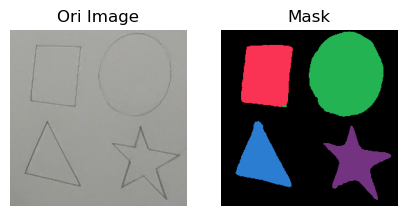

65/65 [==============================] - 9s 139ms/step - loss: 0.0418 - dice: 0.9783 - accuracy: 0.9859 - val_loss: 0.0653 - val_dice: 0.9749 - val_accuracy: 0.9810 - lr: 8.0531e-05


In [20]:
history = unet_model.fit(train_dataloader, validation_data=val_dataloader, epochs=250, callbacks=callbacks)

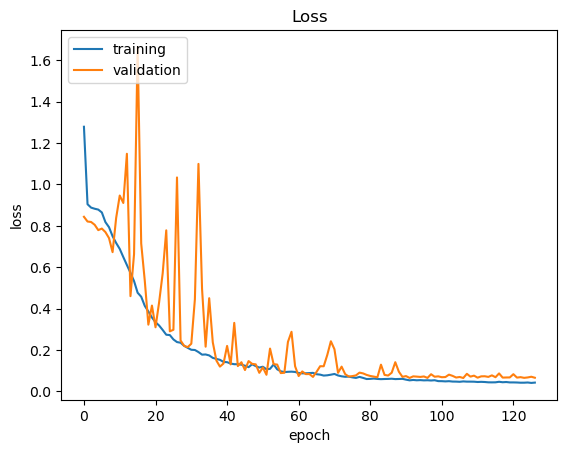

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

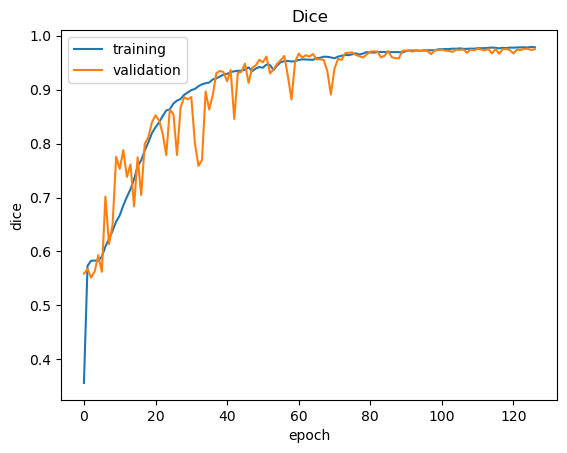

In [29]:
plt.plot(history.history['dice'])
plt.plot(history.history['val_dice'])
plt.title('Dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

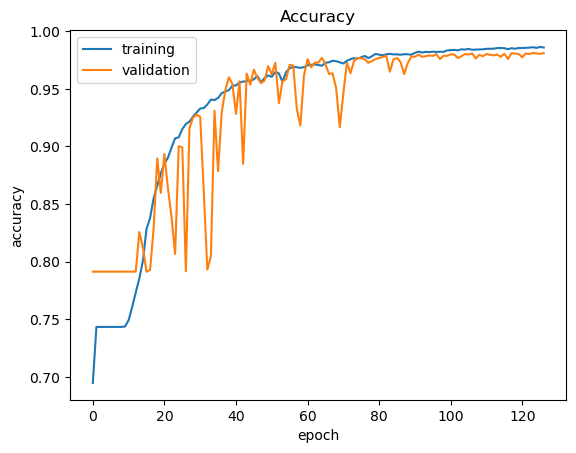

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [31]:
y_pred = unet_model.predict(val_dataloader[0][0])

1/1 [==============================] - 0s 35ms/step


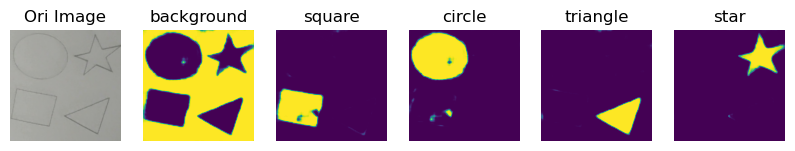

In [32]:
visualize_mask(val_dataloader[0][0][7], y_pred[7])

In [33]:
unet_model.save('/kaggle/working/model10.h5')

In [34]:
# zip to download file
!zip -r '/kaggle/working/images.zip' '/kaggle/working/Images'

updating: kaggle/working/Images/ (stored 0%)
updating: kaggle/working/Images/Epoch13.png (deflated 5%)
updating: kaggle/working/Images/Epoch23.png (deflated 5%)
updating: kaggle/working/Images/Epoch25.png (deflated 5%)
updating: kaggle/working/Images/Epoch118.png (deflated 5%)
updating: kaggle/working/Images/Epoch17.png (deflated 5%)
updating: kaggle/working/Images/Epoch37.png (deflated 4%)
updating: kaggle/working/Images/Epoch66.png (deflated 5%)
updating: kaggle/working/Images/Epoch82.png (deflated 5%)
updating: kaggle/working/Images/Epoch50.png (deflated 5%)
updating: kaggle/working/Images/Epoch28.png (deflated 5%)
updating: kaggle/working/Images/Epoch40.png (deflated 5%)
updating: kaggle/working/Images/Epoch126.png (deflated 5%)
updating: kaggle/working/Images/Epoch96.png (deflated 5%)
updating: kaggle/working/Images/Epoch4.png (deflated 6%)
updating: kaggle/working/Images/Epoch119.png (deflated 5%)
updating: kaggle/working/Images/Epoch93.png (deflated 5%)
updating: kaggle/working/